In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet50, densenet121, mobilenet_v2, convnext_tiny
import torchvision
import matplotlib.pyplot as plt

In [2]:
def get_cifar10_loaders(batch_size, test_batch_size=None, image_size=32):
	if test_batch_size is None: test_batch_size = batch_size * 2

	transform = torchvision.transforms.Compose([
		torchvision.transforms.Resize(image_size),
		torchvision.transforms.ToTensor(),
		torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
	])

	train_ds = torchvision.datasets.CIFAR10(root='./drive/MyDrive/colab/datasets/cifar-10-py/', train=True, download=True, transform=transform)
	test_ds = torchvision.datasets.CIFAR10(root='./drive/MyDrive/colab/datasets/cifar-10-py/', train=False, download=True, transform=transform)

	train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
	test_dl = torch.utils.data.DataLoader(test_ds, batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True)

	return train_dl, test_dl


def timed(fn):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end) / 1000

In [3]:
if torch.cuda.is_available():
    print('device count:', torch.cuda.device_count())
    device = torch.device(0)
    device_cap = torch.cuda.get_device_capability()
    print(f"GPU {torch.cuda.get_device_name(0)} available with compatibility {device_cap}")
    if device_cap not in ((7, 0), (8, 0), (9, 0)):
        print("GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected.")
else:
    device = torch.device("cpu")
    print("GPU unavailable")

device count: 1
GPU Tesla T4 available with compatibility (7, 5)
GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected.


In [4]:
cifar10, _ = get_cifar10_loaders(1024)
batch, target = next(iter(cifar10))
batch, target = batch.to(device), target.to(device)
batch.size()

Files already downloaded and verified
Files already downloaded and verified


torch.Size([1024, 3, 32, 32])

In [5]:
convnext = convnext_tiny()
convnext.classifier[2] = nn.Linear(in_features=768, out_features=10, bias=True)
convnext = convnext.to(device)

import torch._dynamo
torch._dynamo.reset()
convnext_opt = torch.compile(convnext, mode="reduce-overhead")

In [6]:
with torch.no_grad():
    e = timed(lambda: convnext(batch))[1]
    c = timed(lambda: convnext_opt(batch))[1]
    print('eager:', e)
    print('compiled:', c)

eager: 0.6906097412109375
compiled: 15.420076171875


In [7]:
cifar10, _ = get_cifar10_loaders(96)

eager_ts, compile_ts = [], []


for i, (batch, target) in enumerate(cifar10):
  if i % 100 == 0: print('batch', i)
  batch, target = batch.to(device), target.to(device)

  with torch.no_grad():
    _, eager_t = timed(lambda: convnext(batch))
    _, compile_t = timed(lambda: convnext_opt(batch))

  if i < 10:
    print(f'warm-up batch no. {i} (inc. graph compilation) (e/c): {eager_t} / {compile_t}')
  else:
    eager_ts.append(eager_t)
    compile_ts.append(compile_t)

print(f'median exec time (e/c): {np.median(eager_ts)} / {np.median(compile_ts)}')
print(f'compiled graph is on average {np.median(eager_ts) / np.median(compile_ts)} times faster than eager execution')

Files already downloaded and verified
Files already downloaded and verified
batch 0
warm-up batch no. 0 (inc. graph compilation) (e/c): 0.04652032089233398 / 9.3230712890625
warm-up batch no. 1 (inc. graph compilation) (e/c): 0.01792265510559082 / 0.2601266784667969
warm-up batch no. 2 (inc. graph compilation) (e/c): 0.014779423713684082 / 0.01374617576599121
warm-up batch no. 3 (inc. graph compilation) (e/c): 0.01603500747680664 / 0.013640895843505859
warm-up batch no. 4 (inc. graph compilation) (e/c): 0.014537504196166992 / 0.013664992332458496
warm-up batch no. 5 (inc. graph compilation) (e/c): 0.014551072120666505 / 0.013640992164611817
warm-up batch no. 6 (inc. graph compilation) (e/c): 0.01655868721008301 / 0.008702783584594727
warm-up batch no. 7 (inc. graph compilation) (e/c): 0.02068828773498535 / 0.008689984321594239
warm-up batch no. 8 (inc. graph compilation) (e/c): 0.01208518409729004 / 0.008689663887023925
warm-up batch no. 9 (inc. graph compilation) (e/c): 0.013309311866

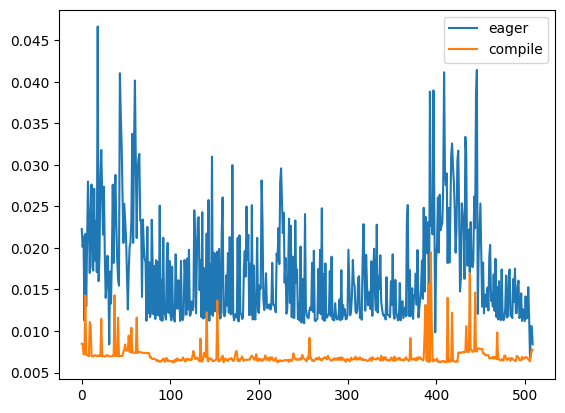

In [8]:
plt.plot(eager_ts, label='eager')
plt.plot(compile_ts, label='compile')
plt.legend()
plt.show()